## Жёлтое такси в Нью-Йорке. Часть 3. 
Финальный проект специализации __Машинное обучение и анализ данных от Яндекса и МФТИ.__

__Задача проекта__ — научиться предсказывать количество поездок в ближайшие часы в каждом районе Нью-Йорка. Для обучения использовались данные с мая 2014 г. по май 2016 г. Прогнозы составлены на июнь 2016 г.

### Прогнозирование ряда со сложной сезонностью
Основная сложность работы с такими рядами, как в нашем проекте, заключается в том, как учесть  сложную структуру сезонности — суточной, недельной и годовой. В рамках моделей ARIMA можно учесть только одну из них. Обычно в таких случаях сезонность с самым маленьким периодом явно моделируют с помощью аримы, а все остальные учитывают за счёт регрессионной компоненты.  

Используем библиотеку holidays для обработки возможных праздников

In [1]:
# !pip install watermark
%load_ext watermark

In [2]:
%watermark -v -m -p numpy,scipy,pandas,matplotlib -g

Python implementation: CPython
Python version       : 3.8.10
IPython version      : 7.28.0

numpy     : 1.20.1
scipy     : 1.6.2
pandas    : 1.2.2
matplotlib: 3.4.3

Compiler    : GCC 9.3.0
OS          : Linux
Release     : 5.4.0-88-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 8
Architecture: 64bit

Git hash: 9c4e9dbcdbca4aacf86d5628b56ed240cdfa5874



In [3]:
# For compatibility with future Python versions
from __future__ import division

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Main system library importing
import os
import sys

# Main modelling libraries importing
import numpy as np
import pandas as pd
import holidays
import datetime

# Main statistical library importing
from scipy import stats as sts
import statsmodels.api as sm
from itertools import product

# Main visual library importing
# Standard visualize
import matplotlib.image as pltimg
from matplotlib import pylab as plt

# To create pipeline functions
from joblib import dump, load

# Main ML libs
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

### Агрегация данных
Рассматриваем данные за перод с декабря 2015 года по май 2016 года. Выберем ячейку содержащую Empire State Building.

In [ ]:
dir_with_count_data = os.path.abspath('/media/tater/MainStorage/TaxiRoutes/count_data')
files_with_count_data = os.listdir(dir_with_count_data)
files_with_count_data.sort()
files_with_count_data

In [143]:
# Получение списка часов в месяце.
def get_hours(date_string):
    now_date = datetime.datetime.strptime(date_string, '%Y-%m-%d %H:%M:%S')
    now_date = now_date.replace(day=1, hour=0, minute=0, second=0)
    target_month = now_date.month
    now_month = now_date.month
    res_list = []
    while now_month == target_month:
        res_list.append(now_date.strftime('%Y-%m-%d %H:%M:%S'))
        now_date = now_date + datetime.timedelta(hours=1)
        now_month = now_date.month
    return res_list

In [ ]:
# Склеиваем датафреймы.
data = None
num_col = 0
hours = 0

for file in files_with_count_data:
    filename = os.path.join(dir_with_count_data, file)
    if data is None:
        data = pd.read_csv(filename, sep=',', header=0, index_col=0)
        num_col += data.shape[1]
        hours += (len(get_hours(data.columns[5])))
        continue
    add_data = pd.read_csv(filename, sep=',', header=0, index_col=0)
    add_data = add_data.iloc[:, 5:]
    hours += (len(get_hours(add_data.columns[0])))
    num_col += add_data.shape[1]
    data = pd.concat([data, add_data], axis=1)

In [ ]:
# Проверка
print(data.shape)

In [ ]:
# Удаление лишних данных
num_of_zones = data.shape[0]
num_of_zeros_zones = 0

drop_indexes = [] # Список ненужных строк
trips = np.array(data.iloc[:, 5:])
for i in range(trips.shape[0]):
    if trips[i].sum() == 0:
        num_of_zeros_zones += 1
        drop_indexes.append(i)
print('Всего {} зон. Количество зон без поездок - {}.'.format(num_of_zones, num_of_zeros_zones))

In [ ]:
# Доверительный интервал. Принимает одномерный массив, возвращает верхнюю границу.
def t_interval(arr):
    mean = arr.mean()
    std = arr.std(ddof=1)
    interval = _tconfint_generic(mean, std, len(arr), 0.05, 'two-sided')
    return interval[1]

In [ ]:
data.shape

In [ ]:
drop_ids = []

for index, row in data.iterrows():
    arr = np.array(row)[5:]
    if arr.mean() < 5:
        drop_ids.append(index)
data.drop(index=drop_ids, inplace=True)
print('Количество ячеек со средним числом поездок меньшим пяти - {}'.format(str(len(drop_ids))))
print('Количество оставшихся ячеек - {}'.format(data.shape[0]))

In [ ]:
dir_with_data = os.path.abspath('/media/tater/MainStorage/TaxiRoutes')
filename = os.path.join(dir_with_data, 'all_count.csv')
filename

In [ ]:
data.to_csv(filename, sep=',', header=True, index=False)

### Чтение данных

In [ ]:
data_n = data.iloc[:, :5].merge(data.iloc[:, -4392:], right_index=True, left_index=True)
data_n.head()

In [4]:
dir_with_data = os.path.abspath('/media/tater/MainStorage/TaxiRoutes')
filename = os.path.join(dir_with_data, '2015_2016_count.csv')
filename

'/media/tater/MainStorage/TaxiRoutes/2015_2016_count.csv'

In [ ]:
data_n.to_csv(filename, sep=',', header=True, index=False)

In [5]:
data_n = pd.read_csv(filename, sep=',')
data_n.head()

,region,west,east,south,north,2015-12-01 00:00:00,2015-12-01 01:00:00,2015-12-01 02:00:00,2015-12-01 03:00:00,2015-12-01 04:00:00,...,2016-05-31 14:00:00,2016-05-31 15:00:00,2016-05-31 16:00:00,2016-05-31 17:00:00,2016-05-31 18:00:00,2016-05-31 19:00:00,2016-05-31 20:00:00,2016-05-31 21:00:00,2016-05-31 22:00:00,2016-05-31 23:00:00
0,1075,-74.022246,-74.011135,40.697437,40.705825,19.0,16.0,8.0,3.0,2.0,...,124.0,105.0,80.0,84.0,106.0,106.0,99.0,84.0,83.0,34.0
1,1076,-74.022246,-74.011135,40.705825,40.714213,43.0,22.0,19.0,12.0,12.0,...,214.0,208.0,156.0,202.0,213.0,167.0,166.0,173.0,98.0,77.0
2,1077,-74.022246,-74.011135,40.714213,40.722601,26.0,12.0,3.0,5.0,3.0,...,104.0,69.0,67.0,109.0,173.0,171.0,165.0,107.0,127.0,58.0
3,1125,-74.011135,-74.000023,40.697437,40.705825,76.0,29.0,9.0,7.0,7.0,...,96.0,70.0,68.0,109.0,126.0,88.0,65.0,78.0,94.0,53.0
4,1126,-74.011135,-74.000023,40.705825,40.714213,91.0,71.0,21.0,17.0,21.0,...,205.0,213.0,168.0,250.0,281.0,293.0,301.0,256.0,174.0,118.0


In [6]:
# Координаты Empire State Building.
longitude = -73.985428
latitude = 40.748817

# Ищем ячейку
cell = data_n[(data_n.west <= longitude) & 
           (data_n.east >= longitude) & 
           (data_n.south <= latitude) & 
           (data_n.north >= latitude)]

# Получаем значения.
trips = np.array(cell).reshape((-1,))[5:]
labels = [datetime.datetime.strptime(i, '%Y-%m-%d %H:%M:%S') for i in list(cell.columns[5:])]

In [7]:
import math

if sys.version_info[0] < 3:
    from Tkinter import Tk, Button, Frame, Canvas, Scrollbar
    import Tkconstants
else:
    from tkinter import Tk, Button, Frame, Canvas, Scrollbar
    import tkinter.constants as Tkconstants

from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import matplotlib.dates as mdates
import pprint, inspect

In [144]:
def addScrollingFigure(figure, frame):
    
    global canvas, mplCanvas, interior, interior_id, cwid
    
    # set up a canvas with scrollbars
    canvas = Canvas(frame)
    canvas.grid(row=1, column=1, sticky=Tkconstants.NSEW)

    xScrollbar = Scrollbar(frame, orient=Tkconstants.HORIZONTAL)
    yScrollbar = Scrollbar(frame)

    xScrollbar.grid(row=2, column=1, sticky=Tkconstants.EW)
    yScrollbar.grid(row=1, column=2, sticky=Tkconstants.NS)

    canvas.config(xscrollcommand=xScrollbar.set)
    xScrollbar.config(command=canvas.xview)
    canvas.config(yscrollcommand=yScrollbar.set)
    yScrollbar.config(command=canvas.yview)

    # plug in the figure
    figAgg = FigureCanvasTkAgg(figure, canvas)
    mplCanvas = figAgg.get_tk_widget()

    # and connect figure with scrolling region
    cwid = canvas.create_window(0, 0, window=mplCanvas, anchor=Tkconstants.NW)
    changeSize(figure, 1)

def changeSize(figure, factor):
    global canvas, mplCanvas, interior, interior_id, frame, cwid
    oldSize = figure.get_size_inches()
    figure.set_size_inches([factor * s for s in oldSize])
    wi,hi = [i*figure.dpi for i in figure.get_size_inches()]
    mplCanvas.config(width=wi, height=hi) # ; printBboxes("A")
    canvas.itemconfigure(cwid, width=wi, height=hi)# ; printBboxes("B")
    canvas.config(scrollregion=canvas.bbox(Tkconstants.ALL),width=200,height=200)
    
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + 
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(item.get_fontsize()*factor)
    ax.xaxis.labelpad = ax.xaxis.labelpad*factor
    ax.yaxis.labelpad = ax.yaxis.labelpad*factor
    #figure.tight_layout() # matplotlib > 1.1.1
    figure.subplots_adjust(left=0.2, bottom=0.15, top=0.86)
    figure.canvas.draw() #; printBboxes("C")

In [145]:
def window_plot(labels, trips, min_lim=None, max_lim=None, title=''):
    """
    Печать в оддельном окне с возможностью прокрутки.
    @param:
    labels -список с datetime.datetime объектами
    min_lim - строка в формате '%Y-%m-%d %H:%M:%S'. Минимальная дата отрисовки
    max_lim - строка в формате '%Y-%m-%d %H:%M:%S'. Максимальная дата отрисовки
    title - заголовок
    """
    
    global root, figure, frame, canvas, ax
    
    frame = None
    canvas = None
    ax = None
    
    if min_lim is None:
        min_lim = labels[0]
    else:
        min_lim = datetime.datetime.strptime(min_lim, '%Y-%m-%d %H:%M:%S')
    
    if max_lim is None:
        max_lim = labels[-1]
    else:
        max_lim = datetime.datetime.strptime(max_lim, '%Y-%m-%d %H:%M:%S')
    
    root = Tk()
    root.rowconfigure(1, weight=1)
    root.columnconfigure(1, weight=1)

    frame = Frame(root)
    frame.grid(column=1, row=1, sticky=Tkconstants.NSEW)
    frame.rowconfigure(1, weight=1)
    frame.columnconfigure(1, weight=1)
    
    
    figure = plt.figure(dpi=100, figsize=(60, 4))
    ax = figure.add_subplot(111)
    ax.plot(labels, trips)
    ax.set_xlim(min_lim, max_lim)
    ax.set_title(title)
    ax.set_xlabel('Trips')
    ax.set_ylabel('Hours')
    
    month = mdates.MonthLocator()
    month_format = mdates.DateFormatter('%Y-%m')
    week_day = mdates.WeekdayLocator()
    ax.xaxis.set_major_locator(month)
    ax.xaxis.set_major_formatter(month_format)
    ax.xaxis.set_minor_locator(week_day)
    ax.grid(True)
    
    addScrollingFigure(figure, frame)

    buttonFrame = Frame(root)
    buttonFrame.grid(row=1, column=2, sticky=Tkconstants.NS)
    biggerButton = Button(buttonFrame, text="larger",
                        command=lambda : changeSize(figure, 1.2))
    biggerButton.grid(column=1, row=1)
    smallerButton = Button(buttonFrame, text="smaller",
                         command=lambda : changeSize(figure, 0.833))
    smallerButton.grid(column=1, row=2)
    qButton = Button(buttonFrame, text="quit",
                         command=lambda :  sys.exit(0))
    qButton.grid(column=1, row=3)

    root.mainloop()

In [21]:
def simple_plot(labels, trips, min_lim=None, max_lim=None, title=''):
    """
    labels -список с datetime.datetime объектами
    min_lim - строка в формате '%Y-%m-%d %H:%M:%S'. Минимальная дата отрисовки
    max_lim - строка в формате '%Y-%m-%d %H:%M:%S'. Максимальная дата отрисовки
    title - заголовок
    """
    month = mdates.MonthLocator()
    month_format = mdates.DateFormatter('%Y-%m')
    week_day = mdates.WeekdayLocator()
    
    
    if min_lim is None:
        min_lim = labels[0]
    else:
        min_lim = datetime.datetime.strptime(min_lim, '%Y-%m-%d %H:%M:%S')
    
    if max_lim is None:
        max_lim = labels[-1]
    else:
        max_lim = datetime.datetime.strptime(max_lim, '%Y-%m-%d %H:%M:%S')
    
    fig, ax = plt.subplots(figsize=(30, 8))
    ax.plot(labels, trips)
    ax.set_xlabel('Hours', fontsize=15)
    #plt.xticks(plot_hours[::label_step], plot_labels[::label_step], rotation='vertical')
    ax.set_ylabel('Trips', fontsize=15)
    ax.xaxis.set_major_locator(month)
    ax.xaxis.set_major_formatter(month_format)
    ax.xaxis.set_minor_locator(week_day)
    """
    for tick in ax.xaxis.get_major_ticks():
        tick.tick1line.set_markersize(0)
        tick.tick2line.set_markersize(0)
        tick.label1.set_horizontalalignment('left')
    """
    ax.grid(True)
    ax.set_xlim(min_lim, max_lim)
    ax.set_title(title, fontsize=30, y=1.01)

In [8]:
# Преобразование в среднее по суткам. Используем только для визуализации.
def mid_day(trips):
    mid_trips = []
    ids = list(range(0,len(trips)+1,24))
    ex_id = 0
    for i in ids:
        if i == 0:
            continue
        mid_trips.append(trips[ex_id:i].mean())
        ex_id = i
    return np.array(mid_trips)

In [9]:
# Преобразование в среднее по неделям. Используем только для визуализации.
def mid_week(trips):
    mid_trips = []
    ids = list(range(0,len(trips)+1,24))
    ex_id = 0
    for i in ids:
        if i == 0:
            continue
        mid_trips.append(trips[ex_id:i].mean())
        ex_id = i
    return np.array(mid_trips)

In [10]:
mid_trips = mid_day(trips)
mid_labels = np.array([labels[i] for i in range(0,len(labels), 24)])

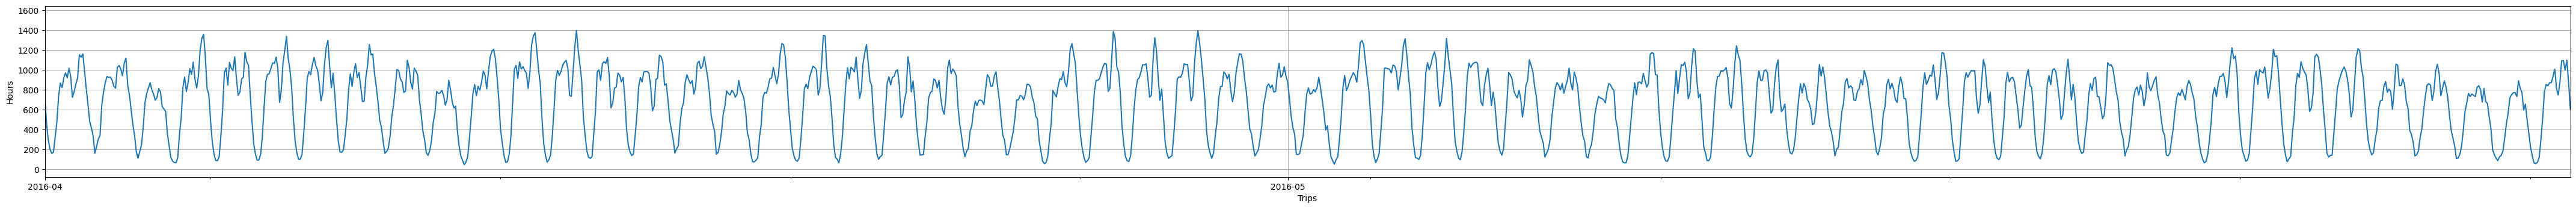

In [146]:
# График за два месяца, печать производится в отдельном окне
window_plot(labels, trips, min_lim='2016-04-01 00:00:00')

Наблюдаем суточную и недельную сезонность.  
График за весь период имеет следующий вид

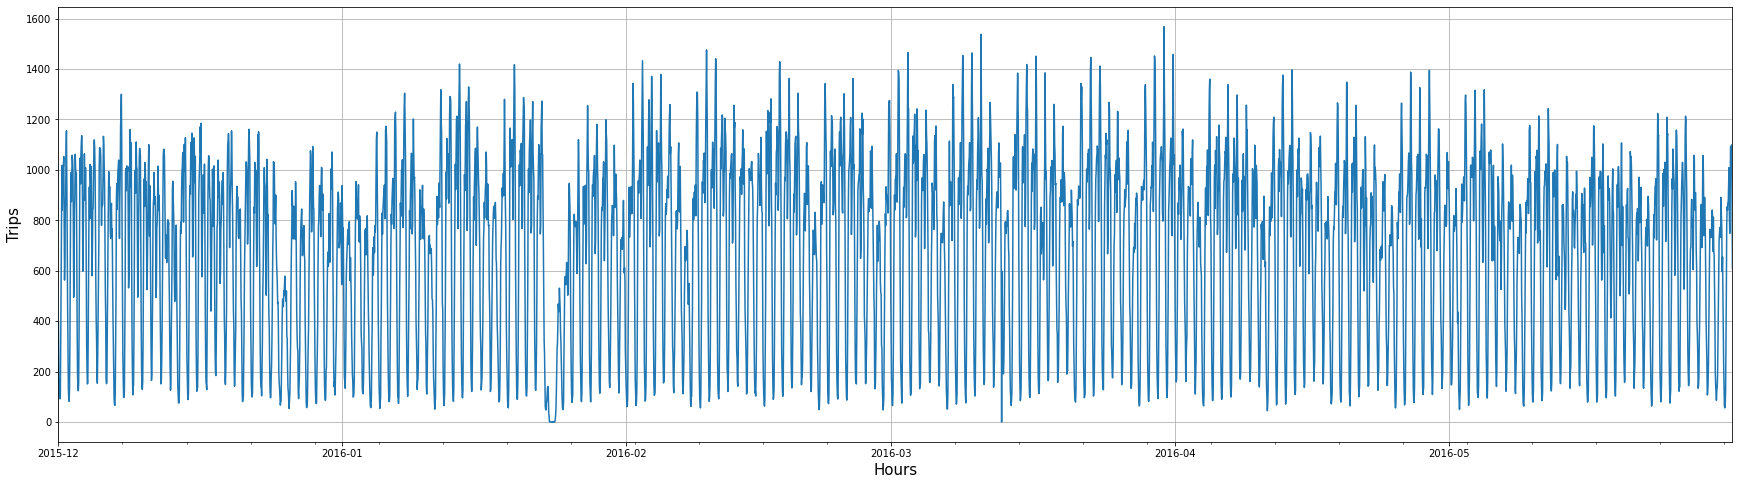

In [147]:
simple_plot(labels, trips)

Итого получили недельную и суточную сезонность.

### Регрессия

In [13]:
from sklearn import linear_model, model_selection, metrics

In [149]:
# Зададим в качестве целевой переменной - количество поездок
# Дата поездки помещена в индекс
cell_data = pd.DataFrame(trips, index=labels, columns=['trips'])
cell_data.head()

,trips
2015-12-01 00:00:00,394.0
2015-12-01 01:00:00,185.0
2015-12-01 02:00:00,109.0
2015-12-01 03:00:00,100.0
2015-12-01 04:00:00,92.0


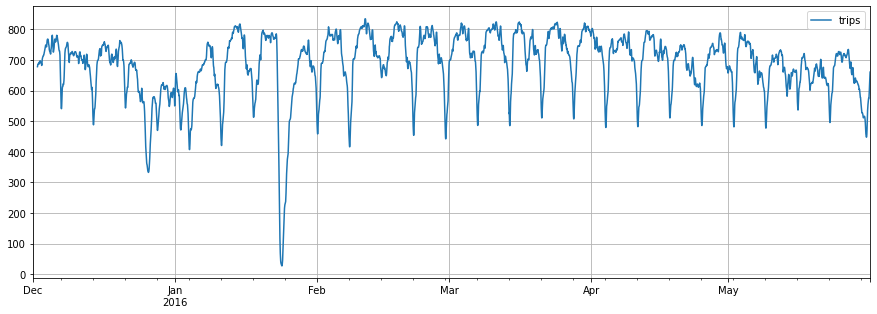

In [150]:
fig, ax = plt.subplots(figsize=(15, 5))
cell_data.rolling(24).mean().plot(ax=ax)
plt.grid(True)
plt.show()

In [119]:
mask = (cell_data.index >= "2016-01-23") & (cell_data.index <= "2016-01-25")
cell_data[mask]

,trips,reg_resid_diff,fitted_values,resid,pred,const,lin,week_sin_1,week_cos_1,week_sin_2,week_cos_2,week_sin_3,week_cos_3,week_sin_4,week_cos_4,week_sin_5,week_cos_5,reg_pred,reg_resid
2016-01-23 00:00:00,718.0,198.116677,-80.405133,135.154847,582.845153,1,1273,-0.467269,-8.841154e-01,8.262388e-01,5.633201e-01,-9.937122e-01,-1.119645e-01,9.308737e-01,-0.365341,-0.652287,7.579717e-01,663.250286,54.749714
2016-01-23 01:00:00,439.0,143.257435,-160.853290,-53.891140,492.891140,1,1274,-0.500000,-8.660254e-01,8.660254e-01,5.000000e-01,-1.000000e+00,-7.348500e-15,8.660254e-01,-0.500000,-0.500000,8.660254e-01,653.744430,-214.744430
2016-01-23 02:00:00,323.0,32.173618,-402.242429,80.368121,242.631879,1,1275,-0.532032,-8.467242e-01,9.009689e-01,4.338837e-01,-9.937122e-01,1.119645e-01,7.818315e-01,-0.623490,-0.330279,9.438833e-01,644.874308,-321.874308
2016-01-23 03:00:00,271.0,138.777021,-483.093542,117.182466,153.817534,1,1276,-0.563320,-8.262388e-01,9.308737e-01,3.653410e-01,-9.749279e-01,2.225209e-01,6.801727e-01,-0.733052,-0.149042,9.888308e-01,636.911076,-365.911076
2016-01-23 04:00:00,151.0,-101.009600,-391.268406,-87.830617,238.830617,1,1277,-0.593820,-8.045978e-01,9.555728e-01,2.947552e-01,-9.438833e-01,3.302791e-01,5.633201e-01,-0.826239,0.037391,9.993007e-01,630.099024,-479.099024
2016-01-23 05:00:00,61.0,-147.249267,-456.598326,-107.047846,168.047846,1,1278,-0.623490,-7.818315e-01,9.749279e-01,2.225209e-01,-9.009689e-01,4.338837e-01,4.338837e-01,-0.900969,0.222521,9.749279e-01,624.646172,-563.646172
2016-01-23 06:00:00,50.0,-70.988023,-452.132851,-118.583125,168.583125,1,1279,-0.652287,-7.579717e-01,9.888308e-01,1.490423e-01,-8.467242e-01,5.320321e-01,2.947552e-01,-0.955573,0.399892,9.165623e-01,620.715976,-570.715976
2016-01-23 07:00:00,48.0,-211.252766,-379.670992,-190.749443,238.749443,1,1280,-0.680173,-7.330519e-01,9.972038e-01,7.473009e-02,-7.818315e-01,6.234898e-01,1.490423e-01,-0.988831,0.563320,8.262388e-01,618.420435,-570.420435
2016-01-23 08:00:00,74.0,-185.049792,-299.370323,-244.444555,318.444555,1,1281,-0.707107,-7.071068e-01,1.000000e+00,1.958816e-15,-7.071068e-01,7.071068e-01,3.917632e-15,-1.000000,0.707107,7.071068e-01,617.814878,-543.814878
2016-01-23 09:00:00,84.0,-35.364090,-404.742024,-130.152599,214.152599,1,1282,-0.733052,-6.801727e-01,9.972038e-01,-7.473009e-02,-6.234898e-01,7.818315e-01,-1.490423e-01,-0.988831,0.826239,5.633201e-01,618.894623,-534.894623


Судя по графику, присутствует аномальное снижение поездок в конце января 2016 года.
Первые запросы в гугле выдали следющую информацию: "Власти США запретили перемещение по городу в связи с аномальными снегопадами 23 января 2016". Тогда все встает на свои места.   
Посмотрим, как модель отреагирует на данное событие, в случае чего, просто пометим его как выброс и уберем из выборки.

Ссылка на источник - [здесь](https://ria.ru/20160123/1364032228.html)

Для учёта недельной сезонности используем регрессионные признаки следующего вида:

$$
s_i = \sin \left( [1,\dots,T] * 2 \pi i/ 8766 \right),\space c_i = \cos \left( [1,\dots,T] * 2 \pi i/ 8766
\right), i=1,\dots, K
$$

In [120]:
# Добавление признаков. 
# Модифицирует датафрейм, возвращеет имена колонок с признаками.
def add_features(cell_data, k):
    
    # Синусы и косинусы.
    cell_data['const'] = 1
    cell_data['lin'] = np.arange(1, cell_data.shape[0]+1)
    real_columns = ['const', 'lin']
    for i in range(1, k+1):
        #year_sin_col = 'year_sin_{}'.format(i)
        #year_cos_col = 'year_cos_{}'.format(i)
        week_sin_col = 'week_sin_{}'.format(i)
        week_cos_col = 'week_cos_{}'.format(i)
        
        #cell_data[year_sin_col] = np.sin(np.array(cell_data['lin'] * 2 * np.pi * i / 8766))
        #cell_data[year_cos_col] = np.cos(np.array(cell_data['lin'] * 2 * np.pi * i / 8766))
        cell_data[week_sin_col] = np.sin(np.array(cell_data['lin'] * 2 * np.pi * i / 168))
        cell_data[week_cos_col] = np.cos(np.array(cell_data['lin'] * 2 * np.pi * i / 168))
        
        #features_columns += [year_sin_col, year_cos_col, week_sin_col, week_cos_col]
        real_columns += [week_sin_col, week_cos_col]
    
    
    return real_columns

In [121]:
# Обучение модели, добаление предсказаний и остатков в датафрейм. Возвращает предсказанные значения.
def get_reg_pred(cell_data, features_columns):
    train_data = np.array(cell_data[features_columns])
    train_labels = np.array(cell_data['trips'])
    
    model = linear_model.LinearRegression()
    model.fit(train_data, train_labels)
    
    preds = model.predict(cell_data[features_columns])
    
    cell_data['reg_pred'] = preds
    cell_data['reg_resid'] = cell_data['trips'] - preds
    
    return preds

In [122]:
# Оценку качества будем проводить через MAPE (mean absolute percentage error),
# в связи с тем, что имеем достаточно большие значения целевой переменной
# Принимает на вход одномерный массив значений
from sklearn.utils import check_array
def mean_absolute_percentage_error(y_true, y_pred):
    MAPE = pd.DataFrame(np.abs((y_true - y_pred) / y_true))
    MAPE = MAPE[MAPE[0] < np.inf]
    return round(np.mean(MAPE[0])*100, 3)

Ошибка прогнозирования: 14.573%


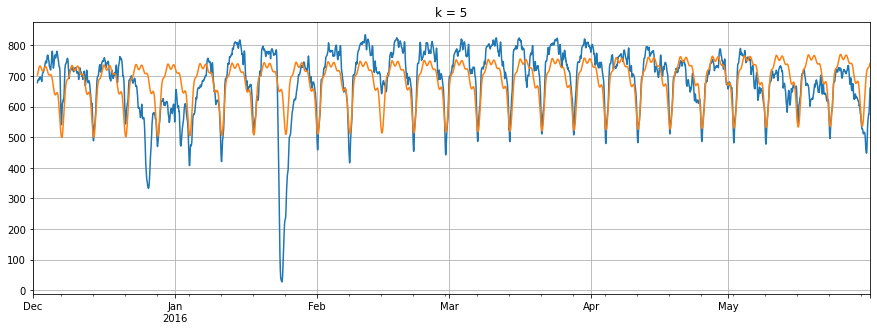

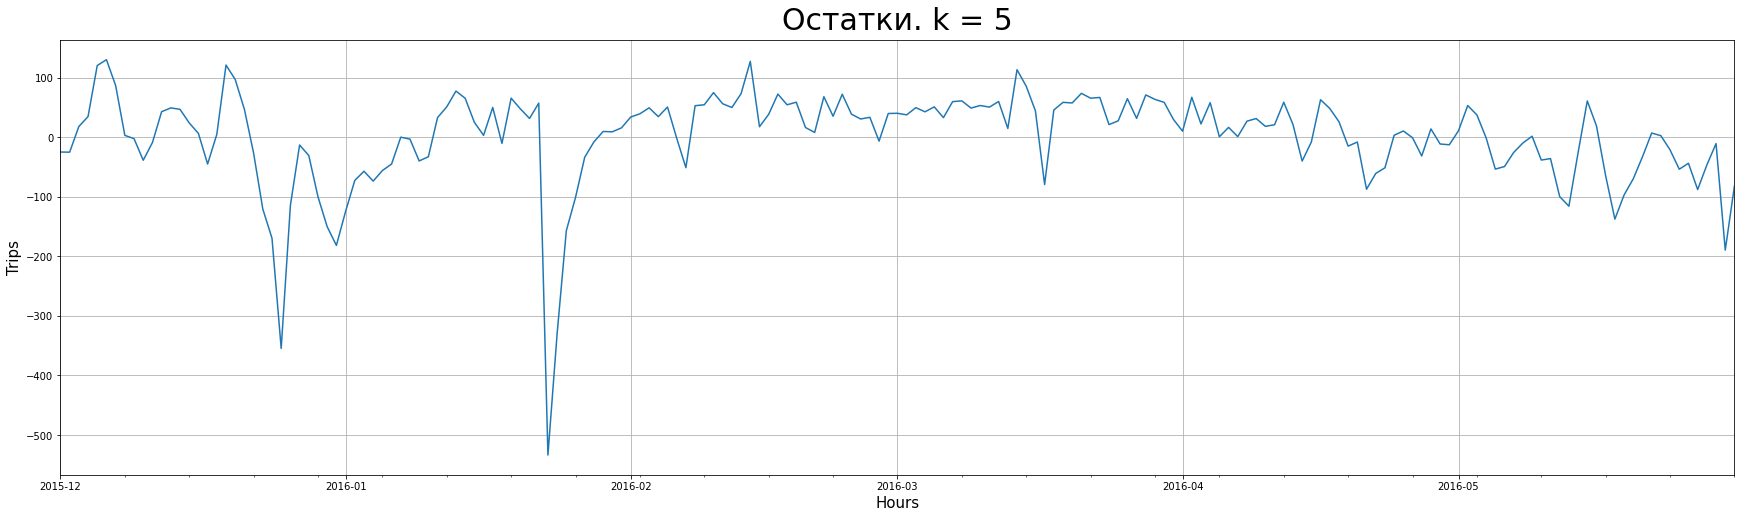

Ошибка прогнозирования: 14.323%


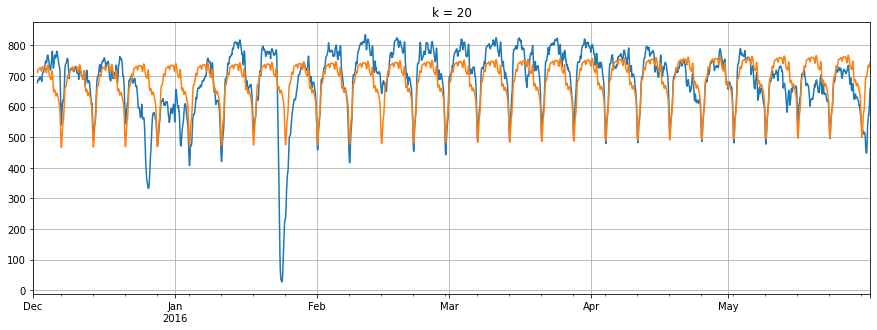

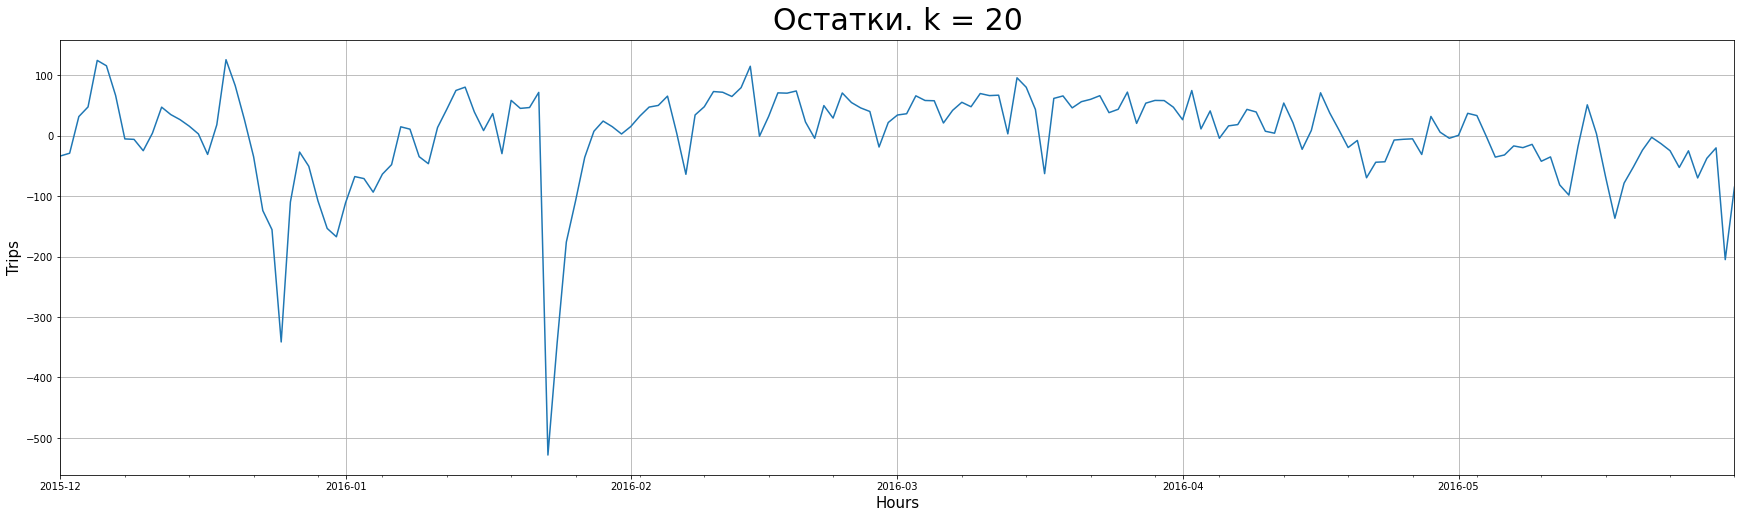

Ошибка прогнозирования: 14.318%


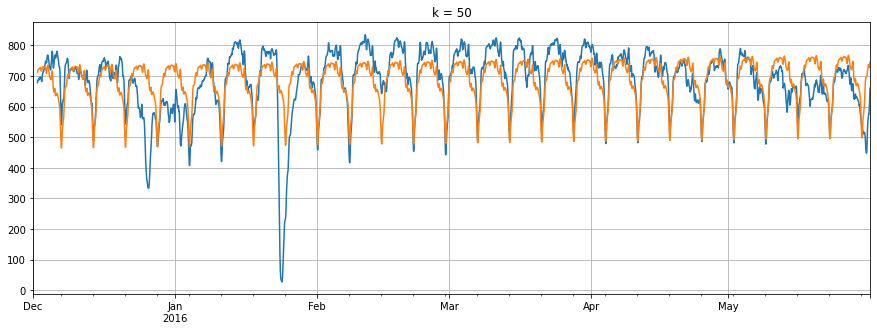

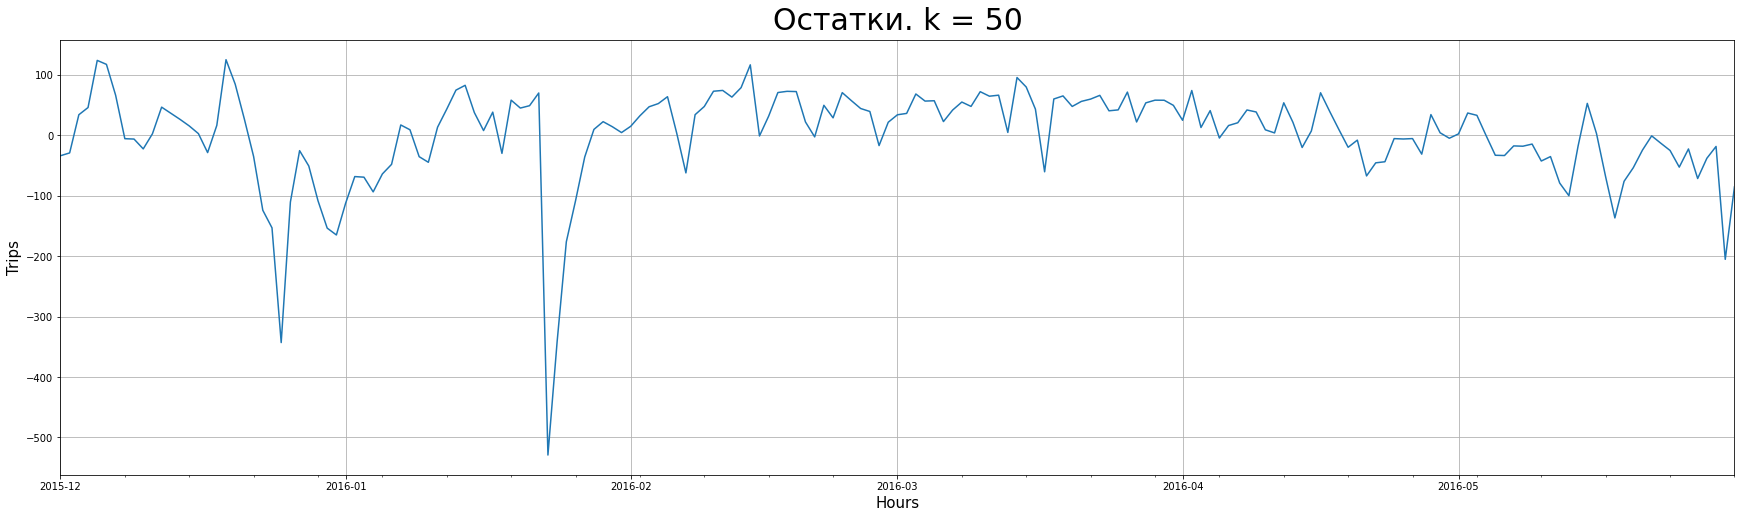

Ошибка прогнозирования: 14.294%


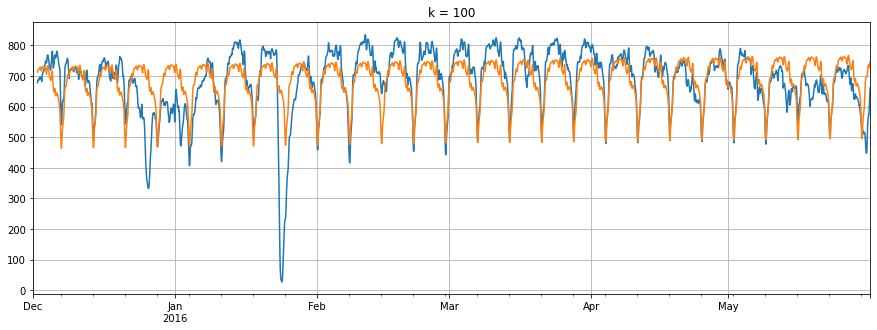

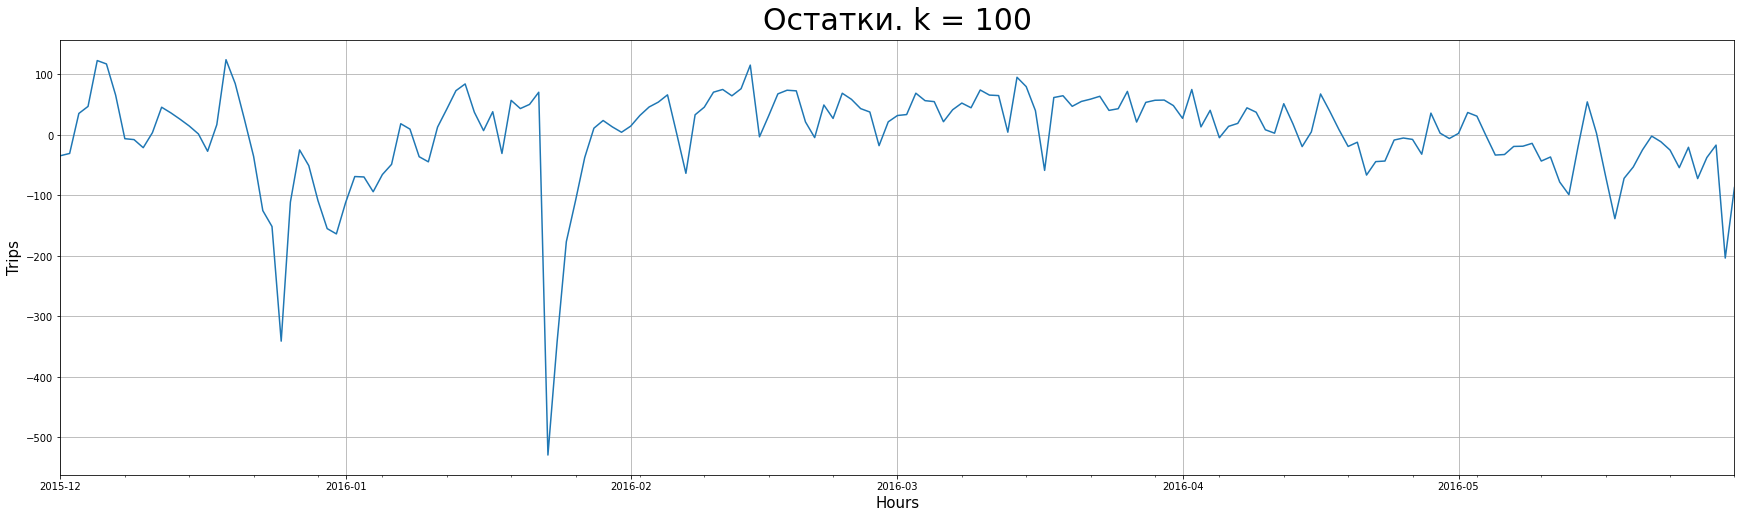

In [123]:
# Подберём К.Организуем банальный перебор параметров в цикле
ks = [5, 20, 50, 100]
for k in ks:
    features_columns = add_features(cell_data, k)
    reg_pred = get_reg_pred(cell_data, features_columns)
    
    # Печать.
    fig, ax = plt.subplots(figsize=(15, 5))
    cell_data['trips'].rolling(24).mean().plot(ax=ax)
    cell_data['reg_pred'].rolling(24).mean().plot(ax=ax)
    MAPE_error = mean_absolute_percentage_error(cell_data['trips'].rolling(24).mean().dropna(), 
                                                cell_data['reg_pred'].rolling(24).mean().dropna())
    print(f"Ошибка прогнозирования: {MAPE_error}%")
    
    ax.set_title('k = {}'.format(k))
    plt.grid(True)
    simple_plot(mid_labels, mid_day(np.array(cell_data['reg_resid'])), title='Остатки. k = {}'.format(k))
    plt.show()
    
    cell_data.drop(columns=features_columns + ['reg_pred', 'reg_resid'], inplace=True)

Что и следовало ожидать аномальный период никак не учитывается в "синусовой" модели

In [124]:
# По визуальной оценке заметно, что увеличение k не играет особой роли для остатков модели.
# В первой итерации примем k=5.

K = 5
features_columns = add_features(cell_data, K)
reg_pred = get_reg_pred(cell_data, features_columns)
# Датафрейм с модельными данными
cell_data['reg_resid'] = cell_data['trips'] - reg_pred
cell_data.head()

,trips,reg_resid_diff,fitted_values,resid,pred,const,lin,week_sin_1,week_cos_1,week_sin_2,week_cos_2,week_sin_3,week_cos_3,week_sin_4,week_cos_4,week_sin_5,week_cos_5,reg_pred,reg_resid
2015-12-01 00:00:00,394.0,NaN,0.000000,-289.162669,683.162669,1,1,0.037391,0.999301,0.074730,0.997204,0.111964,0.993712,0.149042,0.988831,0.185912,0.982566,683.162669,-289.162669
2015-12-01 01:00:00,185.0,NaN,-289.531761,-203.718526,388.718526,1,2,0.074730,0.997204,0.149042,0.988831,0.222521,0.974928,0.294755,0.955573,0.365341,0.930874,678.250287,-493.250287
2015-12-01 02:00:00,109.0,NaN,-492.493591,-72.412399,181.412399,1,3,0.111964,0.993712,0.222521,0.974928,0.330279,0.943883,0.433884,0.900969,0.532032,0.846724,673.905990,-564.905990
2015-12-01 03:00:00,100.0,NaN,-563.493706,-6.890078,106.890078,1,4,0.149042,0.988831,0.294755,0.955573,0.433884,0.900969,0.563320,0.826239,0.680173,0.733052,670.383784,-570.383784
2015-12-01 04:00:00,92.0,NaN,-569.390620,-6.504430,98.504430,1,5,0.185912,0.982566,0.365341,0.930874,0.532032,0.846724,0.680173,0.733052,0.804598,0.593820,667.895050,-575.895050


### ARIMA

ARIMA будет учитывать только остатки от регрессии, без указания exog.
Сделаем декомпозицию остатков после регрессии.

In [151]:
# Печать декомпозиции.
# Отдельная функция для более гибкой настройки декомпозиции. Возможно излишние извороты
def dec_plot(pd_series):
    dec_obj = sm.tsa.seasonal_decompose(pd_series)
    simple_plot(np.array(pd_series.index)[::24][:len(mid_day(dec_obj.observed))], 
                mid_day(dec_obj.observed), title='Observed residuals')

    simple_plot(np.array(pd_series.index)[::24][:len(mid_day(dec_obj.trend))], 
                mid_day(dec_obj.trend), title='Trend residuals')
    simple_plot(np.array(pd_series.index), np.array(dec_obj.seasonal), title='Seasonality residuals')
    simple_plot(np.array(pd_series.index)[::24][:len(mid_day(dec_obj.observed))], 
                mid_day(dec_obj.resid), title='Residuals of residuals')
    return dec_obj

In [153]:
_ = dec_plot(cell_data['reg_resid'])

Уже по визуальной оценке можно сделать вывод, что ряд сильно нестационарен.  
Далее применим стандартные стратегии по созданию стационарного ряда данных

Дважды продифференциурем по суточной сезонности. Далее применим обычное дифференцирование 

In [125]:
diff_period = 24
resid_col = 'reg_resid'
diff_col = 'reg_resid_diff'

# Суточное дифференцирование первого порядка
cell_data[diff_col] = cell_data[resid_col] - cell_data[resid_col].shift(diff_period)
# Суточное дифференцирование второго порядка
cell_data[diff_col] = cell_data[diff_col] - cell_data[diff_col].shift(diff_period)
# Обычное дифференцирование
cell_data[diff_col] = cell_data[diff_col] - cell_data[diff_col].shift(1)

In [48]:
# При проведении дифференцирования неизбежно наличие NaN значений.
# Уберем их и построим график после преобразований
dec_plot(cell_data[diff_col].dropna())

В соответствии с заданием стационарность оцениваем визуально по графикам:  
1) Тренд отсутствует  
2) Дисперсия стабильна (если не считать аномалий)  
3) Сезонность (кроме суточной) отсутствует

#### Выбор начальных приближений для p, q, P, Q
Используем классический метод с ACF и PACF   
Функция для ACF - sm.graphics.tsa.plot_acf
Функция для PACF - sm.graphics.tsa.plot_pacf

Не забываем про удаление несущствующих значений NaN
Очень хороший разбор данных графиков с избранными случаями - [здесь](https://www.youtube.com/watch?v=lnqz4MLGmEo)

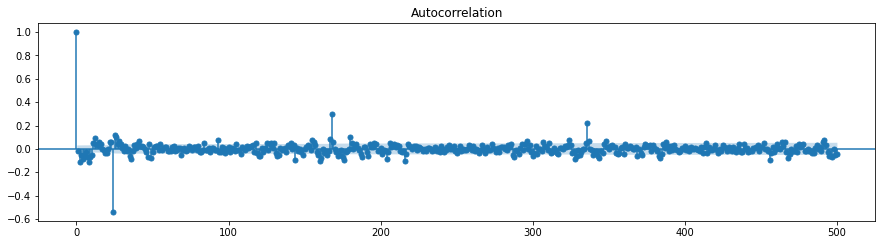

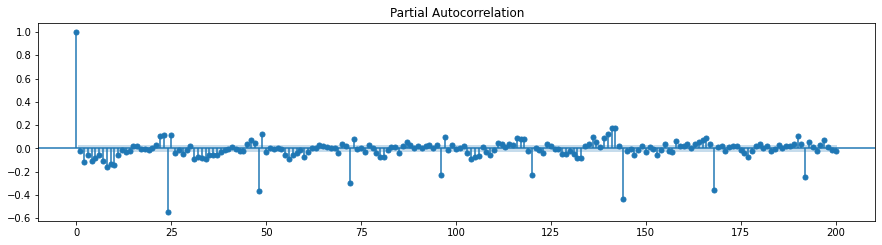

In [49]:
plt.figure(figsize=(15,8))
# одновременно строим поле для двух графиков
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(cell_data[diff_col].dropna().values.squeeze(), lags=500, ax=ax)
plt.show()

plt.figure(figsize=(15,8))
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(cell_data[diff_col].dropna().values.squeeze(), lags=200, ax=ax)
plt.show()

Слишком много лагов, в таком масштабе трудно различить. Воспользуемся печатью в новом окне с возможностью увеличения данных.
Отловим последний значимый лаг (входящий в синюю область) для корелляционной и автокорелляционной функций

In [154]:
# Функция для печати в отдельном окне.
def window_autocor_plot(pd_series, lags, cor='acf', figsize=(100, 4)):
    """
    cor - тип авторкорелляции. 'acf' или 'pacf'.
    """
    
    global root, figure, frame, canvas, ax
    
    frame = None
    canvas = None
    ax = None
        
    root = Tk()
    root.rowconfigure(1, weight=1)
    root.columnconfigure(1, weight=1)

    frame = Frame(root)
    frame.grid(column=1, row=1, sticky=Tkconstants.NSEW)
    frame.rowconfigure(1, weight=1)
    frame.columnconfigure(1, weight=1)
    
    
    figure = plt.figure(dpi=100, figsize=figsize)
    ax = figure.add_subplot(111)
    if cor == 'acf':
        sm.graphics.tsa.plot_acf(pd_series.dropna().values.squeeze(), lags=lags, ax=ax)
    elif cor == 'pacf':
        sm.graphics.tsa.plot_pacf(pd_series.dropna().values.squeeze(), lags=lags, ax=ax)
    else:
        print('Wrong cor parameter')
    ax.xaxis.set_ticks(np.arange(0, lags, 10))
    ax.grid(True)
    addScrollingFigure(figure, frame)

    buttonFrame = Frame(root)
    buttonFrame.grid(row=1, column=2, sticky=Tkconstants.NS)
    biggerButton = Button(buttonFrame, text="larger",
                        command=lambda : changeSize(figure, 1.2))
    biggerButton.grid(column=1, row=1)
    smallerButton = Button(buttonFrame, text="smaller",
                         command=lambda : changeSize(figure, 0.833))
    smallerButton.grid(column=1, row=2)
    qButton = Button(buttonFrame, text="quit",
                         command=lambda :  sys.exit(0))
    qButton.grid(column=1, row=3)

    root.mainloop()

In [ ]:
window_autocor_plot(cell_data[diff_col], lags=500, cor='acf')

In [ ]:
window_autocor_plot(cell_data[diff_col], lags=200, cor='pacf')

In [50]:
# Исходя из просмотренных графиков принимаем начальные приближения коэффициентов
# Для обычной составляющей
p = 21
d = 1
q = 20
# Для сезонной составляющей
P = 7
D = 2
Q = 2

In [51]:
# Общее количество параметров к перебору
ps = [i for i in range(p+1)]
qs = [i for i in range(q+1)]
Ps = [i for i in range(P+1)]
Qs = [i for i in range(Q+1)]
parameters = product(ps, qs, Ps,Qs)
parameters = list(parameters)
print(f'Общее количество различных комбинаций параметров: {len(parameters)}')

Общее количество различных комбинаций параметров: 11088


Получаем просто __огромное количество различных комбинаций.__  
Создание оптимальной модели займет огромное количество времени просто в связи с перебором всех комбинаций

In [ ]:
%%time
# Обучение модели
results = []
best_aic = float('inf')
warnings.filterwarnings('ignore')
print('Всего', str(len(parameters)))
i = 0
for param in parameters:
    i += 1
    print(i, '-', param, '...', datetime.datetime.now(), '...')
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model = sm.tsa.statespace.SARIMAX(cell_data['reg_resid'], order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 24)).fit()
    
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError or np.linalg.LinAlgError or np.linalg.linalg.LinAlgError:
        print('...WRONG')
        continue
    aic_res = model.aic
    
    #сохраняем лучшую модель, aic, параметры
    if aic_res < best_aic:
        best_model = model
        best_aic = aic_res
        best_param = param
    results.append([param, model.aic])
warnings.filterwarnings('default')

Перебор занимал огромное количество времени, оттого было решение оставить только лучший результат.
Данные см. ниже

In [52]:
%%time
best_model = sm.tsa.statespace.SARIMAX(cell_data['reg_resid'], order=(5, 1, 15), 
                                        seasonal_order=(1, 2, 0, 24)).fit()

/home/tater/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/home/tater/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/home/tater/.local/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


CPU times: user 1h 32min 27s, sys: 55min, total: 2h 27min 27s
Wall time: 19min 12s


In [53]:
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                            reg_resid   No. Observations:                 4392
Model:             SARIMAX(5, 1, 15)x(1, 2, [], 24)   Log Likelihood              -27269.861
Date:                              Tue, 25 Jan 2022   AIC                          54583.721
Time:                                      14:04:47   BIC                          54724.000
Sample:                                  12-01-2015   HQIC                         54633.239
                                       - 05-31-2016                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9244      0.040    -23.290      0.000      -1.002      -0.847
ar.L2         -1.4311      0.050    -28.433      0.000      -1.530      -1.332
ar.L3         -1.3148      0.057    -22.999      0.000      -1.427      -1.203
ar.L4         -0.5667      0.049    -11.530      0.000      -0.663      -0.470
ar.L5         -0.5044      0.039    -12.919      0.000      -0.581      -0.428
ma.L1          0.9020      5.121      0.176      0.860      -9.134      10.938
ma.L2          1.2864      9.737      0.132      0.895     -17.797      20.370
ma.L3          1.0311     16.327      0.063      0.950     -30.969      33.031
ma.L4         -0.1273     21.607     -0.006      0.995     -42.476      42.222
ma.L5         -0.3387     20.959     -0.016      0.987     -41.417      40.740
ma.L6         -0.9132     19.229     -0.047      0.962     -38.601      36.775
ma.L7         -0.9080     14.553     -0.062      0.950     -29.432      27.616
ma.L8         -0.7461      9.906     -0.075      0.940     -20.162      18.670
ma.L9         -0.6156      6.086     -0.101      0.919     -12.544      11.313
ma.L10        -0.6784      2.935     -0.231      0.817      -6.431       5.074
ma.L11        -0.4730      0.542     -0.873      0.383      -1.535       0.589
ma.L12        -0.1218      2.961     -0.041      0.967      -5.926       5.682
ma.L13         0.0518      3.588      0.014      0.988      -6.980       7.084
ma.L14         0.3006      3.326      0.090      0.928      -6.218       6.819
ma.L15         0.3501      1.789      0.196      0.845      -3.157       3.857
ar.S.L24      -0.5150      0.021    -24.536      0.000      -0.556      -0.474
sigma2      2.589e+04   1.33e+05      0.195      0.845   -2.34e+05    2.86e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.92   Jarque-Bera (JB):               513.32
Prob(Q):                              0.34   Prob(JB):                         0.00
Heteroskedasticity (H):               0.91   Skew:                             0.03
Prob(H) (two-sided):                  0.06   Kurtosis:                         4.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.67e+14. Standard errors may be unstable.
"""

In [ ]:
# params = results[0][0]
p = params[0]
q = params[1]
P = params[2]
Q = params[3]
print('p = {}, d = {}, q = {}, P = {}, D = {}, Q = {}'.format(p, d, q, P, D, Q))

In [126]:
# Предсказания и остатки
cell_data['fitted_values'] = best_model.fittedvalues
cell_data['resid'] = best_model.resid
cell_data['pred'] = cell_data['reg_pred'] +  cell_data['fitted_values']

#### Анализ остатков

Критерий Стьюдента: p=0.95
Критерий Дики-Фуллера: p=3.9992621918801023e-25


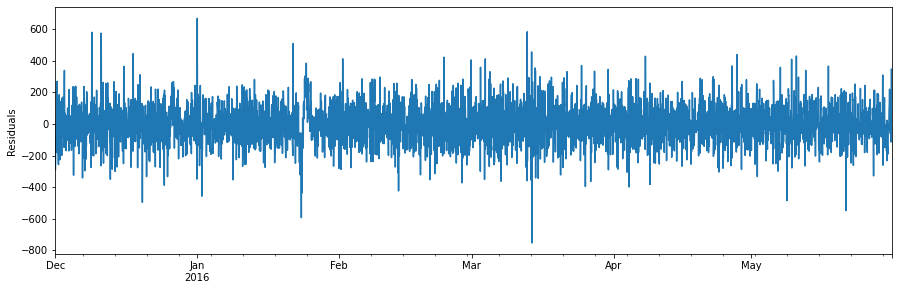

In [127]:
plt.figure(figsize=(15,10))
plt.subplot(211)
best_model.resid.plot()
plt.ylabel('Residuals')

#ax = plt.subplot(212)
#sm.graphics.tsa.plot_acf(best_model.resid.values.squeeze(), lags=50, ax=ax)

print('Критерий Стьюдента: p={:.2f}'.format(sts.ttest_1samp(best_model.resid.dropna(), 0)[1]))
print('Критерий Дики-Фуллера: p={}'.format(sm.tsa.stattools.adfuller(best_model.resid.dropna())[1]))
# print('Критерий Льюнга-Бокса: p={}'.format(float(str(best_model.summary().tables[2]).split()[8])))


plt.show()

В остатках видна структура в аномальный период.

### Предсказание. Анализ результатов.

In [155]:
# Печать в отдельном окне.
def window_fitted_plot(labels, trips, preds, min_lim=None, max_lim=None, title=''):
    
    global root, figure, frame, canvas, ax
    
    frame = None
    canvas = None
    ax = None
    
    if min_lim is None:
        min_lim = labels[0]
    else:
        min_lim = datetime.datetime.strptime(min_lim, '%Y-%m-%d %H:%M:%S')
    
    if max_lim is None:
        max_lim = labels[-1]
    else:
        max_lim = datetime.datetime.strptime(max_lim, '%Y-%m-%d %H:%M:%S')
    
    root = Tk()
    root.rowconfigure(1, weight=1)
    root.columnconfigure(1, weight=1)

    frame = Frame(root)
    frame.grid(column=1, row=1, sticky=Tkconstants.NSEW)
    frame.rowconfigure(1, weight=1)
    frame.columnconfigure(1, weight=1)
    
    
    figure = plt.figure(dpi=100, figsize=(60, 4))
    ax = figure.add_subplot(111)
    ax.plot(labels, trips)
    ax.plot(labels, preds, color='r')
    ax.set_xlim(min_lim, max_lim)
    ax.set_title(title)
    ax.set_xlabel('Trips')
    ax.set_ylabel('Hours')
    
    month = mdates.MonthLocator()
    month_format = mdates.DateFormatter('%Y-%m')
    week_day = mdates.WeekdayLocator()
    ax.xaxis.set_major_locator(month)
    ax.xaxis.set_major_formatter(month_format)
    ax.xaxis.set_minor_locator(week_day)
    ax.grid(True)
    
    addScrollingFigure(figure, frame)

    buttonFrame = Frame(root)
    buttonFrame.grid(row=1, column=2, sticky=Tkconstants.NS)
    biggerButton = Button(buttonFrame, text="larger",
                        command=lambda : changeSize(figure, 1.2))
    biggerButton.grid(column=1, row=1)
    smallerButton = Button(buttonFrame, text="smaller",
                         command=lambda : changeSize(figure, 0.833))
    smallerButton.grid(column=1, row=2)
    qButton = Button(buttonFrame, text="quit",
                         command=lambda :  sys.exit(0))
    qButton.grid(column=1, row=3)

    root.mainloop()

In [59]:
def simple_fitted_plot(labels, trips, preds, min_lim=None, max_lim=None, title=''):
    """
    labels -список с datetime.datetime объектами
    min_lim - строка в формате '%Y-%m-%d %H:%M:%S'. Минимальная дата отрисовки
    max_lim - строка в формате '%Y-%m-%d %H:%M:%S'. Максимальная дата отрисовки
    title - заголовок
    """
    month = mdates.MonthLocator()
    month_format = mdates.DateFormatter('%Y-%m')
    week_day = mdates.WeekdayLocator()
    
    
    if min_lim is None:
        min_lim = labels[0]
    else:
        min_lim = datetime.datetime.strptime(min_lim, '%Y-%m-%d %H:%M:%S')
    
    if max_lim is None:
        max_lim = labels[-1]
    else:
        max_lim = datetime.datetime.strptime(max_lim, '%Y-%m-%d %H:%M:%S')
    
    fig, ax = plt.subplots(figsize=(30, 8))
    ax.plot(labels, trips)
    ax.plot(labels, preds, color='r')
    ax.set_xlabel('Hours', fontsize=15)
    #plt.xticks(plot_hours[::label_step], plot_labels[::label_step], rotation='vertical')
    ax.set_ylabel('Trips', fontsize=15)
    ax.xaxis.set_major_locator(month)
    ax.xaxis.set_major_formatter(month_format)
    ax.xaxis.set_minor_locator(week_day)
    """
    for tick in ax.xaxis.get_major_ticks():
        tick.tick1line.set_markersize(0)
        tick.tick2line.set_markersize(0)
        tick.label1.set_horizontalalignment('left')
    """
    ax.grid(True)
    ax.set_xlim(min_lim, max_lim)
    ax.set_title(title, fontsize=30, y=1.01)

Ошибка прогнозирования: 45.363%


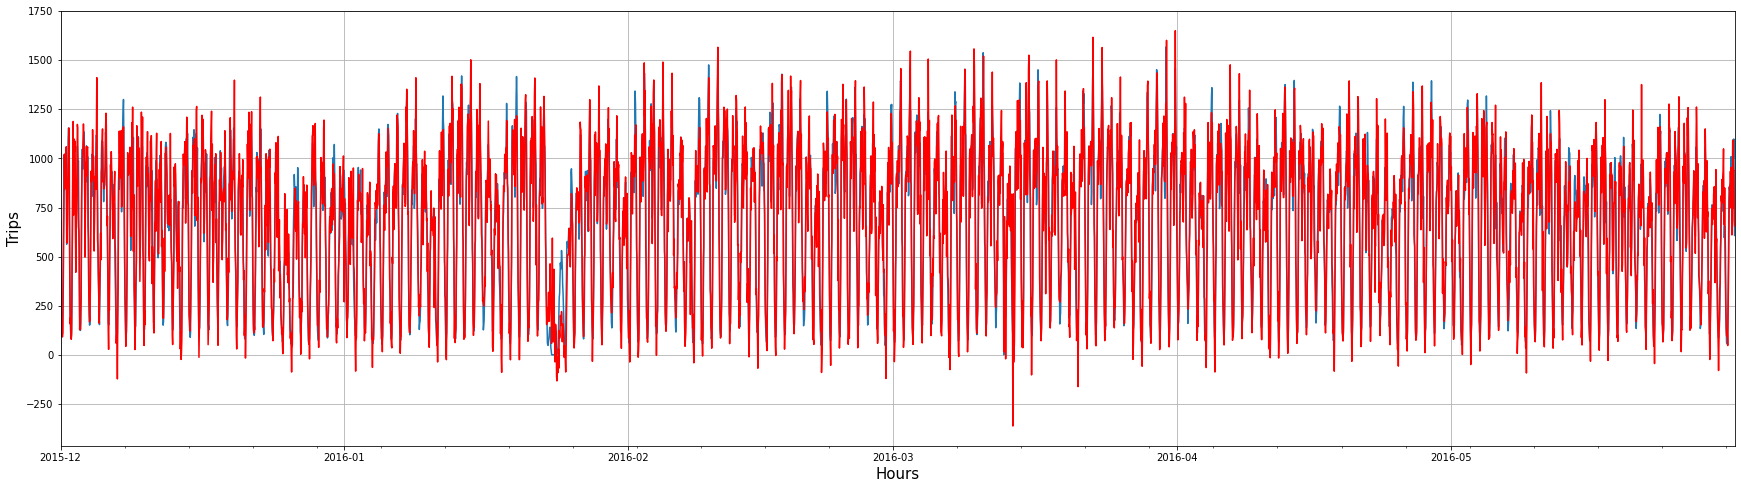

In [128]:
simple_fitted_plot(labels, np.array(cell_data['trips']), 
                   np.array(cell_data['pred']))
MAPE_error = mean_absolute_percentage_error(cell_data['trips'].values, cell_data['pred'].values)
print(f"Ошибка прогнозирования: {MAPE_error}%")

In [ ]:
window_fitted_plot(labels, np.array(cell_data['trips']), 
                   np.array(cell_data['pred']), 
                   min_lim='2016-04-01 00:00:00')

Результат полохо описывает данные в аномальной зоне, и в целом так себе. Попробуем увеличить значение К, и добавить новые признаки.

### Добавление дополнительных признаков

Увеличим К, добавим категориальные признаки месяца, дня недели, логарифм количества дней с прошедшего праздника.  
Примем К=20.

In [129]:
cell_data.drop(columns=features_columns + ['reg_pred', 'reg_resid', 'reg_resid_diff', 'fitted_values', 'pred', 'resid'], inplace=True)

In [130]:
# Количество дней до ближайшего праздника. Не использовалось.
def day_before_holiday(day):
    ny_holidays = holidays.CountryHoliday('US', state='NY')
    res = 0
    temp_day = day
    while temp_day not in ny_holidays:
        res += 1
        temp_day = temp_day + datetime.timedelta(days=1)
    return res

In [131]:
# Количество дней после ближайшего прошедшего праздника.
def day_after_holiday(day):
    ny_holidays = holidays.CountryHoliday('US', state='NY')
    res = 0
    temp_day = day
    while temp_day not in ny_holidays:
        res += 1
        temp_day = temp_day - datetime.timedelta(days=1)
    return res

In [132]:
# Добавление признаков. 
# Модифицирует датафрейм, возвращеет имена колонок с признаками.
def add_features(cell_data, k):
    
    # Синусы и косинусы.
    cell_data['const'] = 1
    cell_data['lin'] = np.arange(1, cell_data.shape[0]+1)
    real_columns = ['const', 'lin']
    for i in range(1, k+1):
        #year_sin_col = 'year_sin_{}'.format(i)
        #year_cos_col = 'year_cos_{}'.format(i)
        week_sin_col = 'week_sin_{}'.format(i)
        week_cos_col = 'week_cos_{}'.format(i)
        
        #cell_data[year_sin_col] = np.sin(np.array(cell_data['lin'] * 2 * np.pi * i / 8766))
        #cell_data[year_cos_col] = np.cos(np.array(cell_data['lin'] * 2 * np.pi * i / 8766))
        cell_data[week_sin_col] = np.sin(np.array(cell_data['lin'] * 2 * np.pi * i / 168))
        cell_data[week_cos_col] = np.cos(np.array(cell_data['lin'] * 2 * np.pi * i / 168))
        
        #features_columns += [year_sin_col, year_cos_col, week_sin_col, week_cos_col]
        real_columns += [week_sin_col, week_cos_col]
    
    # Дни недели.
    weekdays = ['monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday']
    days = cell_data.index
    days = np.array([i.weekday() + 1 for i in days])
    res = OneHotEncoder(sparse=False).fit_transform(days.reshape((-1,1)))
    for i in range(len(weekdays)):
        cell_data[weekdays[i]] = res[:, i]
    categorical_columns = weekdays
    
    # Месяцы. 
    #months_names = ['january', 'february', 'march', 'april', 'may', 'june', 
              #'jule', 'august', 'september', 'october', 'november', 'december']
    months_names = ['december', 'january', 'february', 'march', 'april', 'may']
    months = cell_data.index
    months = np.array([i.month%12 + 1 for i in months])
    res = OneHotEncoder(sparse=False).fit_transform(months.reshape((-1,1)))
    for i in range(len(months_names)):
        cell_data[months_names[i]] = res[:, i]
    categorical_columns += months_names
    
    # Праздники.
    cell_data['days_after_holidays'] = np.log(np.array([day_after_holiday(i) for i in cell_data.index]) + 1)
    real_columns += ['days_after_holidays']
    
    # Масштабирование.
    #vals = StandardScaler().fit_transform(np.array(cell_data[real_columns]))
    #for i in range(len(real_columns)):
     #   cell_data[real_columns[i]] = vals[:, i]
    
    features_columns = real_columns + categorical_columns
    
    return features_columns

In [133]:
K = 20
features_columns = add_features(cell_data, K)
reg_pred = get_reg_pred(cell_data, features_columns)
cell_data['reg_resid'] = cell_data['trips'] - reg_pred
cell_data.head()

,trips,const,lin,week_sin_1,week_cos_1,week_sin_2,week_cos_2,week_sin_3,week_cos_3,week_sin_4,...,sunday,december,january,february,march,april,may,days_after_holidays,reg_pred,reg_resid
2015-12-01 00:00:00,394.0,1,1,0.037391,0.999301,0.074730,0.997204,0.111964,0.993712,0.149042,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.791759,423.515988,-29.515988
2015-12-01 01:00:00,185.0,1,2,0.074730,0.997204,0.149042,0.988831,0.222521,0.974928,0.294755,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.791759,218.525725,-33.525725
2015-12-01 02:00:00,109.0,1,3,0.111964,0.993712,0.222521,0.974928,0.330279,0.943883,0.433884,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.791759,74.667252,34.332748
2015-12-01 03:00:00,100.0,1,4,0.149042,0.988831,0.294755,0.955573,0.433884,0.900969,0.563320,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.791759,13.542186,86.457814
2015-12-01 04:00:00,92.0,1,5,0.185912,0.982566,0.365341,0.930874,0.532032,0.846724,0.680173,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.791759,41.893454,50.106546


In [134]:
# Аналогичные преобразования: два раза дифференцируем по суточной сезонности и один раз обычной дифференцирование
diff_period = 24
resid_col = 'reg_resid'
diff_col = 'reg_resid_diff' 
cell_data[diff_col] = cell_data[resid_col] - cell_data[resid_col].shift(diff_period)
cell_data[diff_col] = cell_data[diff_col] - cell_data[diff_col].shift(diff_period)
cell_data[diff_col] = cell_data[diff_col] - cell_data[diff_col].shift(1)

#### Выбор новых начальных приближений для p, q, P, Q

In [ ]:
window_autocor_plot(cell_data[diff_col], lags=500, cor='acf')

In [ ]:
window_autocor_plot(cell_data[diff_col], lags=200, cor='pacf')

In [135]:
# Исходя из просмотренных графиков принимаем новые начальные приближения коэффициентов
# Для обычной составляющей
p = 23
d = 1
q = 23
# Для сезонной составляющей
P = 7
D = 2
Q = 2

In [136]:
# Общее количество параметров к перебору
ps = [i for i in range(p+1)]
qs = [i for i in range(q+1)]
Ps = [i for i in range(P+1)]
Qs = [i for i in range(Q+1)]
parameters = product(ps, qs, Ps,Qs)
parameters = list(parameters)
print(f'Общее количество различных комбинаций параметров: {len(parameters)}')

Общее количество различных комбинаций параметров: 13824


In [142]:
%%time
# Обучение новой модели
results = []
best_aic = float('inf')
warnings.filterwarnings('ignore')
print('Всего', str(len(parameters)))
i = 0
for param in parameters:
    i += 1
    print(i, '-', param, '...', datetime.datetime.now(), '...')
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model = sm.tsa.statespace.SARIMAX(cell_data['reg_resid'], order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 24)).fit()
    
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError or np.linalg.LinAlgError or np.linalg.linalg.LinAlgError:
        print('...WRONG')
        continue
    aic_res = model.aic
    
    #сохраняем лучшую модель, aic, параметры
    if aic_res < best_aic:
        best_model = model
        best_aic = aic_res
        best_param = param
    results.append([param, model.aic])
warnings.filterwarnings('default')

Как и в предыдущем случае перебор требовал большого количества времени.  
Оставлена только лучшая модель

In [138]:
best_model = sm.tsa.statespace.SARIMAX(cell_data['reg_resid'], order=(21, 1, 22), 
                                        seasonal_order=(0, 2, 0, 24)).fit()

In [139]:
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                       
=============================================================================================
Dep. Variable:                             reg_resid   No. Observations:                 4392
Model:             SARIMAX(21, 1, 22)x(0, 2, [], 24)   Log Likelihood              -26692.705
Date:                               Tue, 25 Jan 2022   AIC                          53473.409
Time:                                       15:25:53   BIC                          53753.967
Sample:                                   12-01-2015   HQIC                         53572.445
                                        - 05-31-2016                                         
Covariance Type:                                 opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2016      0.109     -1.842      0.066      -0.416       0.013
ar.L2         -0.0765      0.079     -0.968      0.333      -0.231       0.078
ar.L3         -0.1563      0.071     -2.188      0.029      -0.296      -0.016
ar.L4          0.4941      0.057      8.614      0.000       0.382       0.607
ar.L5         -0.0098      0.041     -0.241      0.810      -0.090       0.070
ar.L6         -0.5995      0.039    -15.431      0.000      -0.676      -0.523
ar.L7         -0.0980      0.078     -1.263      0.207      -0.250       0.054
ar.L8         -0.0937      0.063     -1.497      0.134      -0.216       0.029
ar.L9         -0.0901      0.058     -1.554      0.120      -0.204       0.024
ar.L10         0.3138      0.055      5.680      0.000       0.205       0.422
ar.L11        -0.0191      0.048     -0.400      0.689      -0.112       0.074
ar.L12        -0.2619      0.045     -5.880      0.000      -0.349      -0.175
ar.L13        -0.0027      0.052     -0.051      0.959      -0.105       0.100
ar.L14        -0.1094      0.048     -2.268      0.023      -0.204      -0.015
ar.L15         0.0425      0.048      0.884      0.377      -0.052       0.137
ar.L16         0.2138      0.044      4.808      0.000       0.127       0.301
ar.L17        -0.0397      0.043     -0.918      0.359      -0.124       0.045
ar.L18         0.0385      0.038      1.000      0.317      -0.037       0.114
ar.L19        -0.0336      0.039     -0.867      0.386      -0.110       0.042
ar.L20        -0.2151      0.039     -5.582      0.000      -0.291      -0.140
ar.L21         0.0521      0.051      1.020      0.308      -0.048       0.152
ma.L1          0.0287      0.429      0.067      0.947      -0.813       0.870
ma.L2         -0.2783      0.413     -0.674      0.500      -1.088       0.531
ma.L3         -0.0265      0.307     -0.086      0.931      -0.628       0.575
ma.L4         -0.7527      0.307     -2.452      0.014      -1.354      -0.151
ma.L5         -0.0130      0.109     -0.118      0.906      -0.228       0.202
ma.L6          1.0441      0.075     13.963      0.000       0.898       1.191
ma.L7          0.0351      0.440      0.080      0.936      -0.827       0.897
ma.L8         -0.2689      0.444     -0.606      0.545      -1.139       0.601
ma.L9         -0.0284      0.320     -0.089      0.929      -0.656       0.600
ma.L10        -0.7842      0.325     -2.412      0.016      -1.422      -0.147
ma.L11         0.0061      0.122      0.050      0.960      -0.233       0.246
ma.L12         1.0490      0.064     16.282      0.000       0.923       1.175
ma.L13         0.0348      0.443      0.079      0.937      -0.833       0.903
ma.L14        -0.2443      0.440     -0.555      0.579      -1.107       0.618
ma.L15        -0.0302      0.336     -0.090      0.928      -0.689       0.628
ma.L16        -0.8076    

In [ ]:
params = results[0][0]
p = params[0]
q = params[1]
P = params[2]
Q = params[3]
print('p = {}, d = {}, q = {}, P = {}, D = {}, Q = {}'.format(p, d, q, P, D, Q))

In [140]:
# Новые предсказания и остатки
cell_data['fitted_values'] = best_model.fittedvalues
cell_data['resid'] = best_model.resid
cell_data['pred'] = cell_data['reg_pred'] +  cell_data['fitted_values']

Ошибка прогнозирования: 41.149%


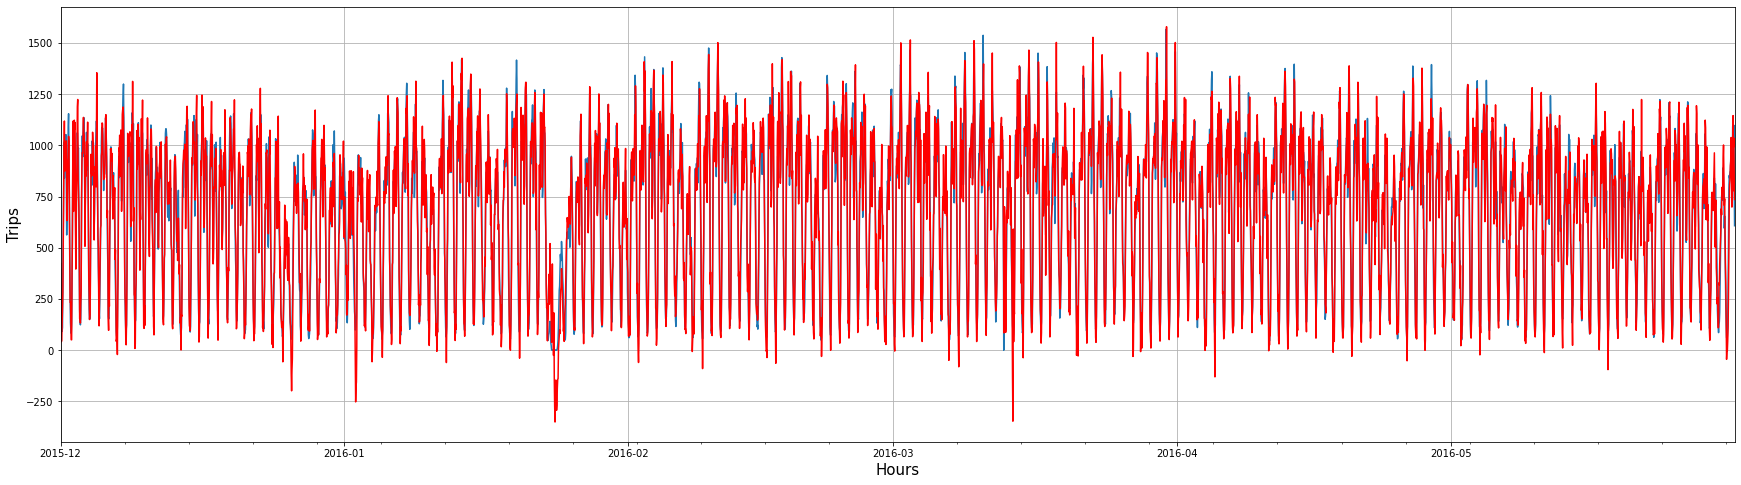

In [141]:
simple_fitted_plot(labels, np.array(cell_data['trips']), 
                   np.array(cell_data['pred']))
MAPE_error = mean_absolute_percentage_error(cell_data['trips'].values, cell_data['pred'].values)
print(f"Ошибка прогнозирования: {MAPE_error}%")

Уже лучше, но все равно плохо описан аномальный период. Оставим данную оценку в качестве первого приближения